In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

import random, os, pathlib, time
from tqdm import tqdm
from sklearn import datasets

In [2]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

## MNIST dataset

In [3]:
import mylibrary.datasets as datasets
import mylibrary.nnlib as tnn

In [4]:
mnist = datasets.FashionMNIST()
# mnist.download_mnist()
# mnist.save_mnist()
train_data, train_label_, test_data, test_label_ = mnist.load()

train_data = train_data / 255.
test_data = test_data / 255.

# train_label = tnn.Logits.index_to_logit(train_label_)
train_size = len(train_label_)

In [5]:
## converting data to pytorch format
train_data = torch.Tensor(train_data)
test_data = torch.Tensor(test_data)
train_label = torch.LongTensor(train_label_)
test_label = torch.LongTensor(test_label_)

In [6]:
input_size = 784
output_size = 10

In [7]:
class MNIST_Dataset(data.Dataset):
    
    def __init__(self, data, label):
        self.data = data
        self.label = label
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
#         print(idx)
        img, lbl = self.data[idx], self.label[idx]
        return img, lbl

In [8]:
train_dataset = MNIST_Dataset(train_data, train_label)
test_dataset = MNIST_Dataset(test_data, test_label)

In [9]:
batch_size = 50
train_loader = data.DataLoader(dataset=train_dataset,
                                    num_workers=4, 
                                    batch_size=batch_size, 
                                    shuffle=True)

test_loader = data.DataLoader(dataset=test_dataset,
                                    num_workers=1, 
                                    batch_size=batch_size, 
                                    shuffle=False)

In [460]:
class DistanceTransform(nn.Module):
    
    def __init__(self, input_dim, num_centers, p=2):
        super().__init__()
        self.input_dim = input_dim
        self.num_centers = num_centers
        self.p = p
        
        self.centers = torch.randn(num_centers, input_dim)/3.
#         self.centers = torch.rand(num_centers, input_dim)
        self.centers = nn.Parameter(self.centers)
        self.inv_params = None
    
    def forward(self, x):
        dists = torch.cdist(x, self.centers, p=self.p)
        
        ### normalize similar to UMAP
#         dists = dists-dists.min(dim=1, keepdim=True)[0]
#         dists = dists-dists.mean(dim=1, keepdim=True)
#         dists = dists/dists.std(dim=1, keepdim=True)

        return dists
    
    def set_centroid_to_data_randomly(self, data_loader):
        indices = np.random.permutation(len(data_loader.dataset.data))[:self.centers.shape[0]]
        self.centers.data = data_loader.dataset.data[indices].to(self.centers.device)
        self.centers.data += torch.randn_like(self.centers)*0.01
        pass
    
    def set_centroid_to_data_maxdist(self, data_loader):
        ## sample N points
        N = self.centers.shape[0]
        new_center = torch.empty_like(self.centers)
        min_dists = torch.empty(N)
        count = 0
        for i, (xx, _) in enumerate(tqdm(data_loader)):
            if count < N:
                if N-count < batch_size:
                    #### final fillup
                    new_center[count:count+N-count] = xx[:N-count]
                    xx = xx[N-count:]
                    dists = torch.cdist(new_center, new_center)+torch.eye(N)*1e5
                    min_dists = dists.min(dim=0)[0]
                    count = N

                else:#### fill the center
                    new_center[count:count+len(xx)] = xx
                    count += len(xx)
                    continue

            ammd = min_dists.argmin()
            for i, x in enumerate(xx):
                dists = torch.norm(new_center-x, dim=1)
                md = dists.min()
                if md > min_dists[ammd]:
                    min_dists[ammd] = md
                    new_center[ammd] = x
                    ammd = min_dists.argmin()
        self.centers.data = new_center.to(self.centers.device)
        pass
        
    
    def set_centroid_to_data(self, data_loader):
        new_center = self.centers.data.clone()
        min_dists = torch.ones(self.centers.shape[0])*1e9

        for xx, _ in data_loader:

            dists = torch.cdist(xx, self.centers.data)
            ### min dist of each center to the data points
            min_d, arg_md = dists.min(dim=0)

            ### dont allow same point to be assigned as closest to multiple centroid
            occupied = []
            for i in np.random.permutation(len(arg_md)):
        #     for i, ind in enumerate(arg_md):
                ind = arg_md[i]
                if ind in occupied:
                    min_d[i] = min_dists[i]
                    arg_md[i] = -1
                else:
                    occupied.append(ind)

            ### the index of centroids that have new min_dist
            idx = torch.nonzero(min_d<min_dists).reshape(-1)

            ### assign new_center to the nearest data point
            new_center[idx] = xx[arg_md[idx]]
            min_dists[idx] = min_d[idx]
            
        self.centers.data = new_center.to(self.centers.device)
        pass
    
    def compute_inverse_matrix(self):
        A = 2*(self.centers.data[1:]-self.centers.data[:-1])
        
        c2 = self.centers.data**2
        Z = (c2[:-1]-c2[1:]).sum(dim=1, keepdim=True)
        
        invA = torch.pinverse(A)
        
        self.inv_params = (invA, Z)
        
    def inverse(self, dists):
        assert invA is not None
        
        d2 = dists**2
        D = d2[:, :-1]-d2[:, 1:]

        invA, Z = self.inv_params
        xrec = torch.matmul(invA, D.t()-Z).t()
        return xrec

In [11]:
class EMA(object):

    def __init__(self, momentum=0.1, mu=None):
        self.mu = mu
        self.momentum = momentum

    def __call__(self, x):
        if self.mu is None:
            self.mu = x
        self.mu = self.momentum*self.mu + (1.0 - self.momentum)*x
        return self.mu

## Inverse function programming

In [368]:
indices = np.random.permutation(len(test_loader.dataset.data))[:50]
xx, yy = test_loader.dataset[indices]

In [369]:
xx

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [418]:
dt = DistanceTransform(784, 100, p=2)
dt.set_centroid_to_data_randomly(train_loader)
dt.centers.data += torch.randn_like(dt.centers)*0.01
# dt.set_centroid_to_data_maxdist(train_loader)
dt.to(device)

DistanceTransform()

In [419]:
dists = dt(xx.to(device))

In [420]:
dists

tensor([[ 9.5916, 14.8464, 12.0628,  ..., 14.2910, 10.2527, 10.1579],
        [10.7364, 13.2698, 13.9123,  ..., 11.5001,  7.7839, 11.9286],
        [11.4181, 14.1490, 14.1074,  ..., 10.7497, 10.9852, 13.3369],
        ...,
        [ 8.9270, 14.7898, 10.8822,  ..., 16.5947, 13.2267,  7.6776],
        [ 6.8252, 11.9767, 11.7552,  ...,  8.3982,  8.5702,  9.9942],
        [10.9388, 14.7640, 13.7783,  ..., 11.6463,  7.0056, 13.3259]],
       device='cuda:0', grad_fn=<ViewBackward>)

In [421]:
#### compute the inverse matrix/vector parameters

A = 2*(dt.centers.data[1:]-dt.centers.data[:-1])
d2 = dists**2
D = d2[:, :-1]-d2[:, 1:]

c2 = dt.centers.data**2
Z = (c2[:-1]-c2[1:]).sum(dim=1, keepdim=True)

In [422]:
A.shape, D.shape, Z.shape

(torch.Size([99, 784]), torch.Size([50, 99]), torch.Size([99, 1]))

In [423]:
# A, D, Z

In [424]:
invA = torch.pinverse(A)
xrec = torch.matmul(invA, D.t()-Z).t()
xrec

tensor([[ 0.0095, -0.0044,  0.0062,  ...,  0.0118, -0.0093, -0.0083],
        [ 0.0075, -0.0107, -0.0056,  ...,  0.0195,  0.0135,  0.0021],
        [ 0.0177,  0.0097, -0.0089,  ..., -0.0375, -0.0463,  0.0087],
        ...,
        [-0.0009,  0.0039, -0.0035,  ...,  0.0077,  0.0319, -0.0022],
        [ 0.0043,  0.0057, -0.0102,  ...,  0.0199,  0.0187,  0.0052],
        [-0.0102,  0.0109, -0.0024,  ..., -0.0380,  0.0076, -0.0036]],
       device='cuda:0', grad_fn=<TBackward>)

In [425]:
xx

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [426]:
iclose = torch.isclose(xrec.data.cpu(), xx, atol=1e-3)
iclose

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [ True, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

In [427]:
print("Not close", torch.numel(xx)-torch.count_nonzero(iclose))

Not close tensor(38653)


In [428]:
i=2

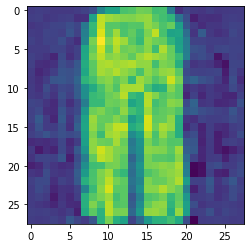

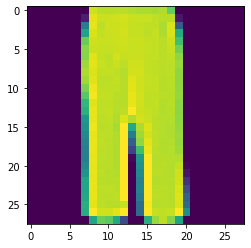

In [459]:
plt.imshow(xrec.data[i].cpu().reshape(28,28))
plt.show()
plt.imshow(xx.data[i].cpu().reshape(28,28))
plt.show()
i+=1

#### For 2D / ND case

In [23]:
nd = 2000
xx = torch.rand(5, nd)*2-1

In [24]:
xx

tensor([[-0.1988, -0.4898, -0.6683,  ..., -0.2005,  0.2330, -0.1519],
        [ 0.3749, -0.1628,  0.9782,  ...,  0.8401,  0.8104, -0.2827],
        [ 0.4490,  0.5505, -0.2476,  ..., -0.9750, -0.8364,  0.2310],
        [-0.1796, -0.3950, -0.0871,  ..., -0.3676,  0.3723,  0.0281],
        [ 0.7756,  0.0282,  0.9532,  ..., -0.9717, -0.0792, -0.1150]])

In [25]:
dt = DistanceTransform(nd, nd+1, p=2)

In [26]:
dists = dt(xx)

In [27]:
dists

tensor([[29.8885, 29.7697, 29.8857,  ..., 30.2374, 30.0821, 29.6521],
        [29.4673, 28.8991, 29.5707,  ..., 29.1595, 29.4923, 29.5889],
        [29.9323, 29.8873, 30.0217,  ..., 29.7485, 29.7305, 29.7226],
        [29.9579, 29.9379, 30.0357,  ..., 30.3834, 29.8568, 30.3314],
        [29.1380, 29.9084, 29.8060,  ..., 29.8752, 29.5153, 30.9829]],
       grad_fn=<ViewBackward>)

In [28]:
#### compute the inverse matrix/vector parameters

A = 2*(dt.centers.data[1:]-dt.centers.data[:-1])
d2 = dists**2
D = d2[:, :-1]-d2[:, 1:]

c2 = dt.centers.data**2
Z = (c2[:-1]-c2[1:]).sum(dim=1, keepdim=True)

In [29]:
A.shape, D.shape, Z.shape

(torch.Size([2000, 2000]), torch.Size([5, 2000]), torch.Size([2000, 1]))

In [30]:
# A, D, Z

In [31]:
invA = torch.pinverse(A)
xrec = torch.matmul(invA, D.t()-Z).t()
xrec

tensor([[-0.1990, -0.4897, -0.6685,  ..., -0.2003,  0.2331, -0.1516],
        [ 0.3756, -0.1626,  0.9786,  ...,  0.8403,  0.8103, -0.2823],
        [ 0.4490,  0.5508, -0.2476,  ..., -0.9744, -0.8365,  0.2312],
        [-0.1796, -0.3949, -0.0869,  ..., -0.3672,  0.3715,  0.0283],
        [ 0.7754,  0.0282,  0.9530,  ..., -0.9715, -0.0794, -0.1151]],
       grad_fn=<TBackward>)

In [32]:
xx

tensor([[-0.1988, -0.4898, -0.6683,  ..., -0.2005,  0.2330, -0.1519],
        [ 0.3749, -0.1628,  0.9782,  ...,  0.8401,  0.8104, -0.2827],
        [ 0.4490,  0.5505, -0.2476,  ..., -0.9750, -0.8364,  0.2310],
        [-0.1796, -0.3950, -0.0871,  ..., -0.3676,  0.3723,  0.0281],
        [ 0.7756,  0.0282,  0.9532,  ..., -0.9717, -0.0792, -0.1150]])

In [33]:
iclose = torch.isclose(xrec.data, xx, atol=1e-3)
iclose

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [34]:
print("Not close", torch.numel(xx)-torch.count_nonzero(iclose))

Not close tensor(319)


In [99]:
Z.shape

torch.Size([2, 1])

In [120]:
A@xx

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x2 and 5x2)